# Bayesian Optimization for Bose-Hubbard BKT w/ BoTorch

### All the BOTorch things we need to import

In [174]:
import torch
from torch import nn
import gpytorch

from botorch.models import SingleTaskGP
from botorch.models import HeteroskedasticSingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.constraints import GreaterThan

from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize

### Some general plotting and helper utilities

In [175]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi as π
import os
import dgutils
from dgutils import colors as colortools

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [176]:
cols = {
 "Purple":"#B39EB5",  
 "Lavender":"#C4C3E9",
 "Teal":"#AEC6CF", 
 "Cyan":"#89CFF0",
 "Sky Blue":"#80B7DE",
 "Blue":"#779ECB", 
 "Red":"#FF6961", 
 "Coral":"#FF9AA2",
 "Sandy Brown":"#F4A460",
 "Orange":"#FFB347",
 "Brown":"#D1A677",
 "Taupe":"#D3B3A6",
 "Magenta":"#CFCFC4",
 "Olive":"#B2B982",
 "Green":"#77DD77",
 "Orchid":"#DA70D6",
 "Light Pink":"#FFB6C1"}

cols_list = list(cols.values())

markers = ['o','s','d','p','h','o','^','>','v','<','D','P']

### Initialize RNG Properties

In [177]:
seed = 88997
torch.manual_seed(seed)

## Load the ground truth DMRG data for $(1-\zeta)^2$

In [178]:
ground_truth = np.loadtxt('../data/flow/flow_dmrg_pbc_data.txt')

### We only want to perform a GP to a subset of the data near the critical point

Here we define $F = 10^3 \times (1-\zeta)^2$

In [179]:
for i,_U in enumerate(ground_truth[:,0]):
    print(i,_U)

0 3.4
1 3.346
2 3.3
3 3.29
4 3.28
5 3.275
6 3.27
7 3.225
8 3.2
9 3.1


In [180]:
U_idx = [9,8,7,6,4,3,2,1,0]
U = np.copy(ground_truth[U_idx,0])
F = np.copy(ground_truth[U_idx,3])*1E3
ΔF = np.copy(ground_truth[U_idx,4])*1E3

### Prepare the training data set

In [181]:
## We make sure that the uncertainty is reduced such that F-ΔF >= 0
idx = np.where(F-ΔF<0)[0]
ΔF[idx] = np.copy(F[idx]-1E-6)

train_X = torch.from_numpy(U).unsqueeze(-1)
train_Y = torch.from_numpy(F).unsqueeze(-1)
train_Yvar = torch.from_numpy(ΔF**2).unsqueeze(-1)

### Just for fun, we see how bad a quadratic fit looks

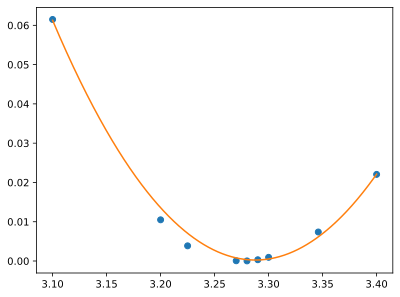

In [182]:
p = np.polyfit(U,F,2,w=ΔF)
pol = np.poly1d(p)
plt.plot(U,F,'o')
np_x = np.linspace(np.min(U),np.max(U),1000)
plt.plot(np_x,pol(np_x),'-')

### A helper function for analyzing our GP

In [183]:
def analyze_gp(mean,std,x):
    np_x = x.numpy()
    np_min = (mean - 1.0 * std).numpy()
    print(f"Negative Mean Function at U/J = : {np_x[np.where(mean<0)]}")

    idx_min = np.where(np_min<=0)[0]
    Uc = np_x[mean.argmin().item()]
    Fc = mean.min().item()
    ΔFc = std[mean.argmin()].item()
    ΔUc = (np_x[idx_min[-1]]-np_x[idx_min[0]])/2
    
    print(np_x[idx_min[0]][0],np_x[idx_min[-1]][0],ΔUc)
    print(f"(U/J)_c = {Uc[0]:.4f} ± {ΔUc[0]:.4f}")
    return float(Uc[0]),float(ΔUc[0]),Fc*1E-5,ΔFc*1E-5

### Some plotting helper utilities

In [184]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

def plot_gp(ax,train_X,train_Y,train_Yvar,test_X,mean,std,zoomed=False, EIpt=None, lower=None, upper=None):

    if lower is None:
        lower = mean - 1.0*std
    if upper is None:
        upper = mean + 1.0*std
    
    # Plot ground truth data
    ax.errorbar(train_X.view(-1).numpy(),train_Y.view(-1).numpy(),np.sqrt(train_Yvar.view(-1).numpy()), marker='o', mec=cols['Red'], 
             mfc=colortools.get_alpha_hex(cols['Red'],0.5, real=True), 
             linestyle='None', ecolor=cols['Red'], label='ground truth')

    # Plot true function
    ax.plot(test_X.view(-1).numpy(), mean.view(-1).numpy(), color=cols['Red'], label="GP mean")

    # Fill ±1 std region (still in original scale)
    ax.fill_between(test_X.view(-1).numpy(),
        lower.numpy(),
        upper.numpy(),
        color=cols['Red'], alpha=0.2, label="posterior CI")

    ax.set_xlabel(r'$U/J$')
    ax.set_ylabel(r"$(1-\zeta)^2 \times 10^3$");
    ax.legend(loc=(0.0,0.0), handlelength=0.75)

    if zoomed:
        axins = zoomed_inset_axes(ax, zoom=100, loc='center', bbox_to_anchor=(0.8,0.78), bbox_transform=ax.transAxes) 

        axins.errorbar(train_X.view(-1).numpy(),train_Y.view(-1).numpy(),np.sqrt(train_Yvar.view(-1).numpy()), 
                       marker='o', mec=cols['Red'], mfc=colortools.get_alpha_hex(cols['Red'],0.5, real=True), 
             linestyle='None', ecolor=cols['Red'], label='Ground Truth')
        
        # Fill ±1 std region (still in original scale)
        axins.fill_between(test_X.view(-1).numpy(),
        lower.numpy(),
        upper.numpy(),
        color=cols['Red'], alpha=0.2, label="±1 Std. Dev.")

        # Plot true function
        axins.plot(test_X.view(-1).numpy(), mean.view(-1).numpy(), color=cols['Red'], label="GP Mean")

        
        axins.set_xlim(3.265, 3.285)
        axins.set_ylim(-0.005*1E-2, 0.019*1E-2)
        axins.set_aspect(50)

        # draw a bbox of the region of the inset axes in the parent axes and
        # connecting lines between the bbox and the inset axes area
        mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.7",joinstyle='round')

        # Mark the predicted minimum
        Uc,ΔUc,Fc,ΔFc = analyze_gp(mean,std,test_X)
        if EIpt == None:
            axins.plot(test_X[mean.argmin()].item(),mean.min().item(), 'x', color=cols['Blue'])
        else:
            axins.plot(EIpt[0],EIpt[1], 'x', color=cols['Blue'])
            
        axins.spines[['right', 'top']].set_visible(False)
        axins.tick_params(top=False, right=False, labeltop=False)  

        
    return ax

## We consider a few mean functions, but ultimately never use them

In [185]:
from gpytorch.means import Mean
from gpytorch.constraints import GreaterThan

class QuadraticMeanConstrained(Mean):
    def __init__(self):
        super().__init__()

        # 1. Register a raw parameter for `a`, which we want to be positive
        self.register_parameter("raw_a", torch.nn.Parameter(torch.ones(1)))
        self.register_constraint("raw_a", gpytorch.constraints.Positive())

        # 2. Register a raw parameter for `b,c` (unconstrained)
        self.register_parameter("raw_b", torch.nn.Parameter(torch.ones(1)))
        self.register_parameter("raw_c", torch.nn.Parameter(torch.zeros(1)))

    @property
    def a(self):
        # Apply the Positive constraint’s transform (softplus by default)
        return self.raw_a_constraint.transform(self.raw_a)

    @property
    def b(self):
        # Unconstrained, so just return it directly
        return self.raw_b
    
    @property
    def c(self):
        # Unconstrained, so just return it directly
        return self.raw_c

    def forward(self, x):
        # x has shape (..., 1) for 1D inputs
        # We'll squeeze out the last dimension to get (...,)
        x_squeezed = x.squeeze(-1)
        
        # Return b*(x-a)**2
        return self.a*(x_squeezed-self.b)**2 + self.c

class QuadraticMean(gpytorch.means.Mean):
    """
    Mean(x) = a*x**2 + b*x + c
    
    This is designed for 1D inputs (shape: (..., 1)).
    """
    def __init__(self):
        super().__init__()
        # Define learnable parameters
        # 173.30437152, -1139.53300864,  1873.22544356
        self.a = nn.Parameter(1*torch.ones(1))
        self.b = nn.Parameter(-1*torch.ones(1))
        self.c = nn.Parameter(1*torch.ones(1))

    def forward(self, x):
        # x has shape (..., 1) for 1D inputs
        # We'll squeeze out the last dimension to get (...,)
        x_squeezed = x.squeeze(-1)
        # Return b*(x-a)**2
        return self.a*x_squeezed**2 + self.b*x_squeezed + self.c
        


## Define and fit a GP model

As we eventually want to maximize the function, we flip the sign of the observations

### A few kernels to try out

Ultimatly we found that Matern is the best (not surprisingly)

In [205]:
from gpytorch.kernels import MaternKernel, RBFKernel, ScaleKernel,PolynomialKernel,RQKernel

rbf_covar = ScaleKernel(base_kernel=RBFKernel())
matern_covar = ScaleKernel(base_kernel=MaternKernel(nu=2.5))
lin_covar = ScaleKernel(base_kernel=PolynomialKernel(power=6))
RQ_covar = ScaleKernel(base_kernel=RQKernel())

In [206]:
#quadratic_mean = QuadraticMean()
gp = SingleTaskGP(train_X=train_X,train_Y=-train_Y,train_Yvar=train_Yvar, 
                  input_transform=Normalize(d=1), outcome_transform=Standardize(m=1),
                 covar_module=matern_covar)
            #     ,mean_module=quadratic_mean)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
mll.train()
fit_gpytorch_model(mll)

# switch to evaluation mode
gp.eval()

# evaluate the GP posterior
test_X = torch.linspace(np.min(U), np.max(U), 1000).unsqueeze(-1)
with torch.no_grad():
    posterior = gp.posterior(test_X)
    mean = -posterior.mean.squeeze(-1)   
    std = posterior.stddev.squeeze(-1)
    lower, upper = posterior.mvn.confidence_region()
    lower *= -1
    upper *= -1

In [203]:
mll.train()

ExactMarginalLogLikelihood(
  (likelihood): FixedNoiseGaussianLikelihood(
    (noise_covar): FixedGaussianNoise()
  )
  (model): SingleTaskGP(
    (likelihood): FixedNoiseGaussianLikelihood(
      (noise_covar): FixedGaussianNoise()
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): PolynomialKernel(
        (raw_offset_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
    (input_transform): Normalize()
  )
)

## Plot the GP Prediciton

Negative Mean Function at U/J = : [[3.272072 ]
 [3.2723725]
 [3.2726727]
 [3.272973 ]
 [3.2732732]
 [3.2735736]
 [3.2738738]
 [3.2741742]
 [3.2744744]
 [3.2747748]
 [3.2750752]
 [3.2753754]
 [3.2756758]
 [3.275976 ]
 [3.2762764]
 [3.2765765]
 [3.276877 ]
 [3.277177 ]
 [3.2774775]]
3.2693694 3.2792792 [0.00495493]
(U/J)_c = 3.2748 ± 0.0050


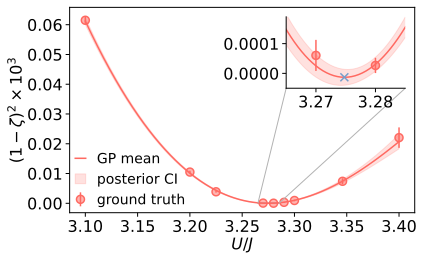

In [204]:
plt.style.reload_library()
with plt.style.context('notebook'):
    fig,ax = plt.subplots()
    ax = plot_gp(ax,train_X,train_Y,train_Yvar,test_X,mean,std, zoomed=True)

## Use Expected Improvement + BO to Propose a Candidate Point

In [164]:
# 3. Define the Expected Improvement (EI) acquisition function
best_f = -train_Y.min()
EI = ExpectedImprovement(model=gp, best_f=best_f)

# 4. Optimize the acquisition function to get the next candidate point
bounds = torch.tensor([[np.min(U)],   # lower bound in 1D
                       [np.max(U)]])  # upper bound in 1D

candidate, acq_value = optimize_acqf(
    acq_function=EI,
    bounds=bounds,
    q=1,                # we want 1 new candidate
    num_restarts=5,     # number of starting points for multistart acquisition optimization
    raw_samples=20,     # number of samples for initialization
)
with torch.no_grad():
    acq_vals = EI(test_X.unsqueeze(-1))

print(f"Proposed new point = {candidate.item():.4f}")
print(f"Acquisition value of proposed point = {acq_value.item():.4f}")

Proposed new point = 3.2753
Acquisition value of proposed point = 0.0000


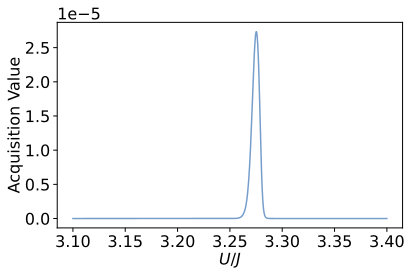

In [165]:
def plot_acquisition(ax,test_X, acq_vals):
    ax.plot(test_X.cpu(), acq_vals, color=cols["Blue"])
    ax.set_xlabel(r'$U/J$')
    ax.set_ylabel("Acquisition Value")
    #ax.set_xlim(3.10,3.40)
    return ax

plt.style.reload_library()
with plt.style.context('notebook'):
    fig,ax = plt.subplots()
    ax = plot_acquisition(ax,test_X, acq_vals)

## Produce a plot of the GP and Acquisition Function

In [172]:
np_x = test_X.numpy()
np_min = (mean - 1.0 * std).numpy()
EI_idx = np.where(abs(np_x-candidate.item())<1.25E-4)[0]
EIpt = (np_x[EI_idx],mean[EI_idx])

Negative Mean Function at U/J = : []
3.26997 3.2792792 [0.00465465]
(U/J)_c = 3.2757 ± 0.0047


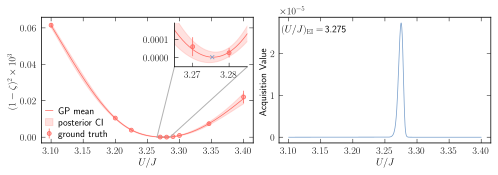

In [173]:
plt.style.reload_library()
with plt.style.context('aps'):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(nrows=1,ncols=2, figsize=(2*figsize[0],1.1*figsize[1]), constrained_layout=True)
    ax[0] = plot_gp(ax[0],train_X,train_Y,train_Yvar,test_X,mean,std, zoomed=True, 
                   EIpt=EIpt)
    ax[1] = plot_acquisition(ax[1],test_X, acq_vals)
    ax[1].text(0.01,0.94,r'$(U/J)_{\rm EI} =\, $'+f'{candidate.item():.3f}',ha='left', 
               va='top', transform=ax[1].transAxes)
    
    plt.savefig('../figures/GP0_acquisition_wzoom.pdf')

## Now we add the point from the BO

In [125]:
U_idx = [9,8,7,6,5,4,3,2,1,0]
U_EI = np.copy(ground_truth[U_idx,0])
F_EI = np.copy(ground_truth[U_idx,3])*1E3
ΔF_EI = np.copy(ground_truth[U_idx,4])*1E3

## We make sure that the uncertainty is reduced such that F-ΔF >= 0
idx = np.where(F_EI-ΔF_EI<0)[0]
ΔF_EI[idx] = np.copy(F_EI[idx]-1E-6)

train_X = torch.from_numpy(U_EI).unsqueeze(-1)
train_Y = torch.from_numpy(F_EI).unsqueeze(-1)
train_Yvar = torch.from_numpy(ΔF_EI**2).unsqueeze(-1)

In [126]:
gp = SingleTaskGP(train_X=train_X,train_Y=-train_Y,train_Yvar=train_Yvar, 
                  input_transform=Normalize(d=1), outcome_transform=Standardize(m=1))
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_model(mll)

# switch to evaluation mode
gp.eval()

# evaluate the GP posterior
test_X = torch.linspace(np.min(U), np.max(U), 200).unsqueeze(-1)
with torch.no_grad():
    posterior = gp.posterior(test_X)
    mean = -posterior.mean.squeeze(-1)   
    std = posterior.stddev.squeeze(-1)

/Users/agdelma/local/miniconda3/lib/python3.9/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Negative Mean Function at U/J = : []
3.2718594 3.2778895 [0.00301504]
(U/J)_c = 3.2764 ± 0.0030
Negative Mean Function at U/J = : []
3.2718594 3.2778895 [0.00301504]
(U/J)_c = 3.2764 ± 0.0030


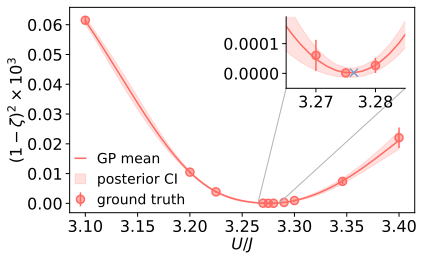

In [127]:
plt.style.reload_library()
with plt.style.context('notebook'):
    fig,ax = plt.subplots()
    ax = plot_gp(ax,train_X,train_Y,train_Yvar,test_X,mean,std, zoomed=True)
    Uc,ΔUc,Fc,ΔFc = analyze_gp(mean,std,test_X)
    
    #ax.text(0.01,0.01, f"$U_c/J = {Uc:.3f} \pm {ΔUc:.3f}$", ha='left', va='bottom',
    #        transform=ax.transAxes)
    plt.savefig('../figures/final_GP_w_BO.pdf')

## GP directly on $\zeta$

In [128]:
def analyze_ζ(x,lower,upper):
    np_x = test_X.numpy()
    np_min = lower.numpy()
    np_max = upper.numpy()
    idx_min = np.where(np_min<=1.0)[0][0]
    idx_max = np.where(np_max<=1.0)[0][0]
    Uc = np_x[np.where(mean<=1.0)[0][0]+1]
    ΔUc = (np_x[idx_max]-np_x[idx_min])/2
    print(f"(U/J)_c = {Uc[0]:.4f} ± {ΔUc[0]:.4f}")
    return float(Uc[0]),float(ΔUc[0])

In [129]:
for i,_U in enumerate(ground_truth[:,0]):
    print(i,_U)

0 3.4
1 3.346
2 3.3
3 3.29
4 3.28
5 3.275
6 3.27
7 3.225
8 3.2
9 3.1


In [137]:
#U_idx = [9,8,6,4,2,0]
U_idx = [9,8,7,6,5,4,3,2,1,0]
U = np.copy(ground_truth[U_idx,0])
ζ = np.copy(ground_truth[U_idx,1])
Δζ = np.copy(ground_truth[U_idx,2])

In [138]:
train_X = torch.from_numpy(U).unsqueeze(-1)
train_Y = torch.from_numpy(ζ).unsqueeze(-1)
train_Yvar = torch.from_numpy(Δζ**2).unsqueeze(-1)

In [139]:
gp = SingleTaskGP(train_X=train_X,train_Y=train_Y,train_Yvar=train_Yvar, 
                  input_transform=Normalize(d=1), outcome_transform=Standardize(m=1),
                 covar_module=matern_covar)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
mll.train()
fit_gpytorch_model(mll)

# switch to evaluation mode
gp.eval()

# evaluate the GP posterior
test_X = torch.linspace(np.min(U), np.max(U), 501).unsqueeze(-1)
with torch.no_grad():
    posterior = gp.posterior(test_X)
    mean = posterior.mean.squeeze(-1)   
    std = posterior.stddev.squeeze(-1)
    lower, upper = posterior.mvn.confidence_region()

In [140]:
def plot_ζ_GP(ax,train_X,train_Y,train_Yvar,test_X,mean,std,zoomed=False, lower=None, upper=None):

    # Plot ground truth data
    ax.errorbar(train_X.view(-1).numpy(),train_Y.view(-1).numpy(),np.sqrt(train_Yvar.view(-1).numpy()), marker='o', mec=cols['Red'], 
             mfc=colortools.get_alpha_hex(cols['Red'],0.5, real=True), 
             linestyle='None', ecolor=cols['Red'], label='ground truth')

    # Plot true function
    ax.plot(test_X.view(-1).numpy(), mean.view(-1).numpy(), color=cols['Red'], label="GP mean")

    # Fill ±1 std region (still in original scale)
    ax.fill_between(test_X.view(-1).numpy(),
        lower.numpy(),
        upper.numpy(),
        color=cols['Red'], alpha=0.2, label="posterior CI")

    ax.set_xlabel(r'$U/J$')
    ax.set_ylabel(r"$\zeta$");
    ax.legend(loc=(0.01,0.28), handlelength=0.75)

    # plot the final value of Uc
    Uc,ΔUc = analyze_ζ(test_X,lower,upper)
    Uc_inv = 1.0/Uc
    ΔUc_inv = Uc_inv*(ΔUc/Uc)
    ax.text(0.05,0.15,f"$U_c/J = {Uc:.3f} \pm {ΔUc:.3f}$",ha='left', 
               va='bottom', transform=ax.transAxes)
    ax.text(0.05,0.04,f"$J/U_c = {Uc_inv:.4f} \pm {ΔUc_inv:.4f}$",ha='left', 
               va='bottom', transform=ax.transAxes)

    if zoomed:
        axins = zoomed_inset_axes(ax, zoom=2.8, loc='center', bbox_to_anchor=(0.8,0.785), bbox_transform=ax.transAxes) 

        axins.errorbar(train_X.view(-1).numpy(),train_Y.view(-1).numpy(),np.sqrt(train_Yvar.view(-1).numpy()), 
                       marker='o', mec=cols['Red'], mfc=colortools.get_alpha_hex(cols['Red'],0.5, real=True), 
             linestyle='None', ecolor=cols['Red'], label='Ground Truth', ms=2)
        
        # Fill ±1 std region (still in original scale)
        axins.fill_between(test_X.view(-1).numpy(),
        lower.numpy(),
        upper.numpy(),
        color=cols['Red'], alpha=0.2, label="post. confidence")

        # Plot true function
        axins.plot(test_X.view(-1).numpy(), mean.view(-1).numpy(), color=cols['Red'], label="GP Mean")

        axins.set_xlim(3.266, 3.304)
        δm,δp = 1.2E-3,5E-4
        axins.set_ylim(1-δm, 1+δp)
        axins.set_aspect(15)

        # if we want extra labels
        #axins.set_yticks(ticks=[1-δm, 1, 1+δp], labels=[f"$1-{δm:.4f}$", "$1$", f"$1+{δp:.4f}$"])
            
        axins.set_yticks(ticks=[1], labels=["$1$"])

        # draw a bbox of the region of the inset axes in the parent axes and
        # connecting lines between the bbox and the inset axes area
        mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.7",joinstyle='round',linewidth=0.5)
        
        axins.spines[['right', 'top']].set_visible(False)

        # Mark some details of the transition
        axins.axhline(y=1,color=cols['Blue'],zorder=-10)
        axins.axvline(x=Uc,color=cols['Blue'],zorder=-10)
        _y = np.linspace(1-δm, 1+δp,100)
        axins.fill_betweenx(_y, Uc-ΔUc, Uc+ΔUc, color=cols['Blue'], alpha=0.1,zorder=-100)
        axins.tick_params(top=False, right=False, labeltop=False)  


    return ax,axins


### Perform a simple linear fit

We use: U/J ∈ {3.300,3.290,3.280,3.275}

In [141]:
from scipy.optimize import curve_fit
def linear_func(x, m, b):
    return m*(x - b) + 1.0

popt, pcov = curve_fit(
    f=linear_func,
    xdata=U[2:6],
    ydata=ζ[2:6],
    sigma=Δζ[2:6],
    absolute_sigma=True
)
m_fit, b_fit = popt
perr = np.sqrt(np.diag(pcov))

(U/J)_c = 3.2758 ± 0.0021


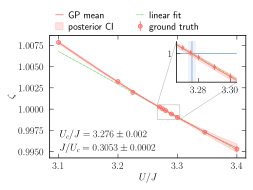

In [142]:
plt.style.reload_library()
with plt.style.context('aps'):
    figsize = plt.rcParams['figure.figsize']
    fig,ax = plt.subplots(figsize=[figsize[0],1.2*figsize[1]],constrained_layout=True)
    ax,axins = plot_ζ_GP(ax,train_X,train_Y,train_Yvar,test_X,mean,std, zoomed=True, lower=lower,upper=upper)
    
    # now we add the linear fit (hard-coded parmmeters for now)
    _U = np.linspace(U.min(),U.max(),1000)
    ax.plot(_U,linear_func(_U,*popt),color=cols["Green"], linestyle='--', zorder=-100, label='linear fit')
    axins.plot(_U,linear_func(_U,*popt),color=cols["Green"], linestyle='--', zorder=0)

    handles, labels = ax.get_legend_handles_labels()
    order = [2, 0, 1,3]  # new order
    handles = [handles[i] for i in order]
    labels = [labels[i] for i in order]

    # Pass the reordered lists to legend
    ax.legend(loc=(0.01,1.0), ncols=2, handlelength=0.75)
    
    plt.savefig('../figures/final_zeta_var.pdf')